## Time Series Deep Learning w/ LSTMs
Here, we will build the LSTM model archiecture and functions to use for the StreamLit application. Here I run a sample submission of a model to make predictions for BitCoin

I owe a lot of credit to my learning of how to build LSTM architectures in PyTorch to the following reference I will include below:

* https://medium.com/analytics-vidhya/pytorch-lstms-for-time-series-forecasting-of-indian-stocks-8a49157da8b9

In [412]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
sns.set()

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
#import datetime as dt

import time
from datetime import datetime
from datetime import date
from datetime import timedelta
import scipy
import scipy.stats
import pylab
import statsmodels.api as sm
from itertools import cycle

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import statsmodels.tsa.stattools as sts
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import OCSBTest
from arch import arch_model
from scipy.stats.distributions import chi2 

import yfinance
from yahoo_fin.stock_info import get_data
from Time_Series_Functions import get_close_column, get_volume_column, create_ticker_table
import warnings
warnings.filterwarnings('ignore')

In [4]:
#here ,we want to make it so users can make an auto arima with whatever exogenous factors they want. 

#then, make an LSTM model from the currency they want to look at. 

Here, we're going to utilize deep learning to see if we can improve the Auto Arima model from the previous notebook using the same data, transforms, and date ranges. 

In [6]:
invasion_date = "2022-02-24"

In [142]:
bitcoin_df = create_ticker_table()

Enter a ticker from Yahoo! Finance. Enter "No" to continue: BTC-USD
Enter a ticker from Yahoo! Finance. Enter "No" to continue: no
Do you want daily or business day data? Enter 'd' for daily and 'b' for business: b

********** Table Head **********


,BTC-USD_Close,BTC-USD_Volume,BTC-USD_Return
2017-01-02,1021.750000,222184992,0.000000
2017-01-03,1043.839966,185168000,2.161974
2017-01-04,1154.729980,344945984,10.623277
2017-01-05,1013.380005,510199008,-12.240955
2017-01-06,902.200989,351876000,-10.971108
2017-01-09,902.828003,141876992,0.069498
2017-01-10,907.679016,115808000,0.537313
2017-01-11,777.757019,310928992,-14.313650
2017-01-12,804.833984,222326000,3.481417
2017-01-13,823.984009,168968000,2.379376


********** Table Tail **********


,BTC-USD_Close,BTC-USD_Volume,BTC-USD_Return
2022-04-18,40826.214844,33705182072,0.672569
2022-04-19,41502.750000,25303206547,1.657110
2022-04-20,41374.378906,27819532341,-0.309307
2022-04-21,40527.363281,35372786395,-2.047198
2022-04-22,39740.320312,28011716745,-1.942004
2022-04-25,40458.308594,35445730570,1.806700
2022-04-26,38117.460938,34569088416,-5.785827
2022-04-27,39241.121094,30981015184,2.947888
2022-04-28,39773.828125,33903704907,1.357522
2022-04-29,38609.824219,30882994649,-2.926557


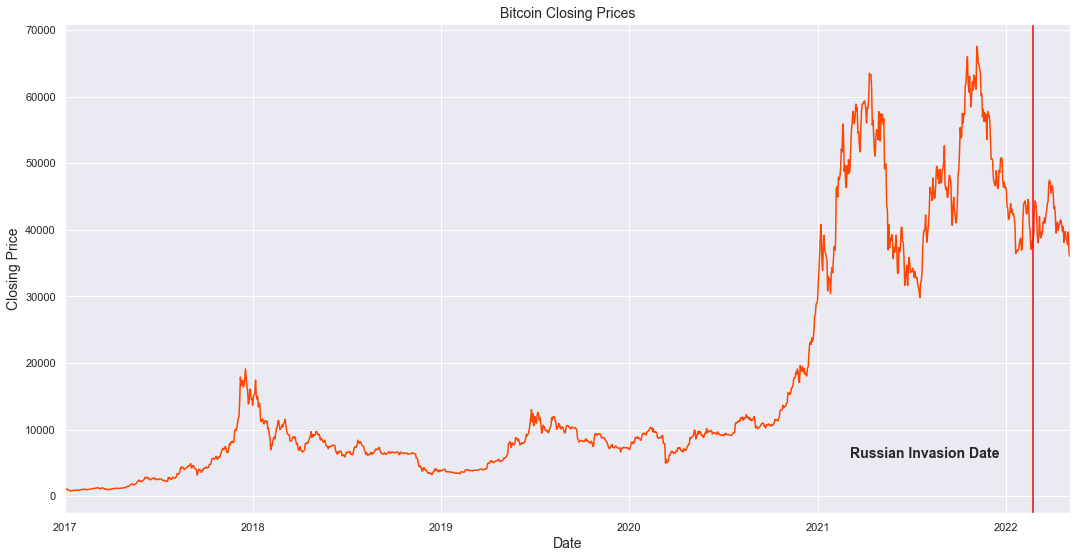

In [143]:
bitcoin_df['BTC-USD_Close'][:invasion_date].plot(figsize=(18,9), color='#FF4500')

bitcoin_df['BTC-USD_Close'][invasion_date:].plot(color='#FE420F')

plt.legend(['Bitcoin'], fontsize=14)
plt.axvline(x=invasion_date, ymin=0, ymax=70000, color='red')
plt.title('Bitcoin Closing Prices', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Closing Price', fontsize=14)
plt.legend('',frameon=False)
plt.annotate('Russian Invasion Date',
            xy=(850, 100), xycoords='figure pixels', weight='bold', fontsize=14)

plt.show()

In [144]:
bitcoin_df['Date'] = bitcoin_df.index
bitcoin_df = bitcoin_df[['Date','BTC-USD_Close','BTC-USD_Volume','BTC-USD_Return']]
bitcoin_df.head()

,Date,BTC-USD_Close,BTC-USD_Volume,BTC-USD_Return
2017-01-02,2017-01-02,1021.750000,222184992,0.000000
2017-01-03,2017-01-03,1043.839966,185168000,2.161974
2017-01-04,2017-01-04,1154.729980,344945984,10.623277
2017-01-05,2017-01-05,1013.380005,510199008,-12.240955
2017-01-06,2017-01-06,902.200989,351876000,-10.971108


In [145]:
bitcoin_df.tail()

,Date,BTC-USD_Close,BTC-USD_Volume,BTC-USD_Return
2022-05-02,2022-05-02,38529.328125,32922642426,-0.208486
2022-05-03,2022-05-03,37750.453125,27326943244,-2.021512
2022-05-04,2022-05-04,39698.371094,36754404490,5.159986
2022-05-05,2022-05-05,36575.140625,43106256317,-7.867402
2022-05-06,2022-05-06,36040.921875,37795577489,-1.460606


In [147]:
truncated_bitcoin_df = bitcoin_df.loc["2020-12-24":"2022-05-04", :] #going up until May 4th to get precise juxtaposition.


In [150]:
#Same function as before to perform transformations

def log_and_shift(series):
    series_log = np.log(series)
    series_diff_log = series_log.shift()
    return series_diff_log[1:]

In [154]:
df_train.head()

,Date,BTC-USD_Close,BTC-USD_Volume,BTC-USD_Return
2020-12-24,2020-12-24,23735.949219,41080759713,2.128119
2020-12-25,2020-12-25,24664.791016,42068395846,3.913228
2020-12-28,2020-12-28,27084.808594,49056742893,9.811628
2020-12-29,2020-12-29,27362.437500,45265946774,1.025036
2020-12-30,2020-12-30,28840.953125,51287442704,5.403450


In [153]:
df_test.head()

,Date,BTC-USD_Close,BTC-USD_Volume,BTC-USD_Return
2022-02-24,2022-02-24,38332.609375,46383802093,2.777840
2022-02-25,2022-02-25,39214.218750,26545599159,2.299894
2022-02-28,2022-02-28,43193.234375,35690014104,10.146870
2022-03-01,2022-03-01,44354.636719,32479047645,2.688852
2022-03-02,2022-03-02,43924.117188,29183112630,-0.970630


In [274]:
scaler = MinMaxScaler()
training_data = sc.fit_transform(bitcoin_df.to_numpy().reshape(-1, 1))
torch.manual_seed(3)

In [487]:
new_bitcoin_df = truncated_bitcoin_df[['Date', 'BTC-USD_Close']]
new_bitcoin_df

,Date,BTC-USD_Close
2020-12-24,2020-12-24,23735.949219
2020-12-25,2020-12-25,24664.791016
2020-12-28,2020-12-28,27084.808594
2020-12-29,2020-12-29,27362.437500
2020-12-30,2020-12-30,28840.953125
...,...,...
2022-04-28,2022-04-28,39773.828125
2022-04-29,2022-04-29,38609.824219
2022-05-02,2022-05-02,38529.328125
2022-05-03,2022-05-03,37750.453125


In [489]:
def generate_data(df, price_col, date_col, n_steps):
    """
    Reads the dataset and based on n_steps/lags to consider in the time series, creates input output pairs
    
    args:
        df (DataFrame): The dataframe to acquire the selected column of data from
        price_col (str): The name of column in the dataframe that holds the closing price for the stock
        date_col (str): The nameo oc column in the dataframe which holds dates values
        n_steps (int): Number of steps/ lags based on which prediction is made
    """

    for idx in range(n_steps):
        df[f"lag_{idx + 1}"] = df[price_col].shift(periods = (idx + 1))
    
    # Create a dataframe which has only the lags and the date
    new_df = df[[date_col, price_col] + [f"lag_{x + 1}" for x in range(n_steps)]]
    new_df = new_df.iloc[n_steps:-1, :]

    # Get a list of dates for which these inputs and outputs are
    dates = list(new_df[date_col])

    # Create input and output pairs out of this new_df
    inputs = []
    outputs = []
    for entry in new_df.itertuples():
        i = entry[-n_steps:][::-1]
        o = entry[-(n_steps + 1)]
        inputs.append(i)
        outputs.append(o)

    return (inputs, outputs, dates)

In [490]:
inputs, labels, dates = generate_data(new_bitcoin_df, 'BTC-USD_Close', 'Date', 5)

In [491]:
def crypto_data_loader(x, y, params):
    """
    Given the inputs, labels and dataloader parameters, returns a pytorch dataloader
    
    args:
        x (list): inputs list
        y (list): target variable list
        params (dict): Parameters pertaining to dataloader eg. batch size
    """
    training_set = CryptoDataset(x, y)
    data_loader = DataLoader(training_set, **params) #torch.utils.data.DataLoader
    return data_loader

In [492]:
class CryptoDataset(Dataset): #torch.utils.data.Dataset
    """
    This class is the dataset class which is used to load data for training the LSTM 
    to forecast timeseries data
    """

    def __init__(self, inputs, outputs):
        """
        Initialize the class with instance variables
        
        args:
            inputs (list): [A list of tuples representing input parameters]
            outputs (list): [A list of floats for the stock price]
        """
        self.inputs = inputs
        self.outputs = outputs
    
    def __len__(self):
        """
        Returns the total number of samples in the dataset
        
        """
        return len(self.outputs)
    
    def __getitem__(self, idx):
        """
        Given an index, it retrieves the input and output corresponding to that index and returns the same
        
        args:
            idx (int): [An integer representing a position in the samples]
        """
        x = torch.FloatTensor(self.inputs[idx])
        y = torch.FloatTensor([self.outputs[idx]])
        
        return (x, y)

In [493]:
def standardize_data(X, scaler = None, train = False):
    """
    Given a list of input features, standardizes them to bring them onto a homogenous scale
    
    args:
        X (dataframe): A dataframe of all the input values
        scaler (object, optional): A StandardScaler object that holds mean and std of a standardized dataset. Defaults to None.
        train (bool, optional): If False, means validation set to be loaded and SS needs to be passed to scale it. Defaults to False.
    """
    if train:
        scaler = StandardScaler()   
        new_X = scaler.fit_transform(X)
        return (new_X, scaler)
    else:
        new_X = scaler.transform(X)
        return new_X #(new_X, None)

In [494]:
class CryptoModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_lyrs = 1, do = .05, device = "cpu"):
        """
        This class initializes the network architecture
        
        args:
            input_dim (int): Number of time lags to look at for current prediction
            hidden_dim (int): The dimension of RNN output
            n_lyrs (int, optional): Number of stacked RNN layers. Defaults to 1.
            do (float, optional): Dropout for regularization. Defaults to .05.
        """
        super(CryptoModel, self).__init__()

        self.ip_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_lyrs
        self.dropout = do
        self.device = device

        self.rnn = nn.LSTM(input_size = input_dim, hidden_size = hidden_dim, num_layers = n_lyrs, dropout = do)
        self.fc1 = nn.Linear(in_features = hidden_dim, out_features = int(hidden_dim / 2))
        self.act1 = nn.ReLU(inplace = True)
        #Including batchnorm seems to engender an error somehow
        #self.bn1 = nn.BatchNorm1d(num_features = int(hidden_dim / 2))

        self.estimator = nn.Linear(in_features = int(hidden_dim / 2), out_features = 1)
        
    
    def init_hiddenState(self, bs):
        """Initialize the hidden state of RNN to all zeros
        Args:
            bs ([int]): [Batch size during training]
        """
        return torch.zeros(self.n_layers, bs, self.hidden_dim)

    def forward(self, input_):
        """
        Define the forward propogation logic here
        
        args:
            input (Tensor): A 3-dimensional float tensor containing parameters
        """
        bs = input_.shape[1]
        hidden_state = self.init_hiddenState(bs).to(self.device)
        cell_state = hidden_state
        
        out, _ = self.rnn(input_, (hidden_state, cell_state))

        out = out.contiguous().view(-1, self.hidden_dim)
        #out = self.act1(self.bn1(self.fc1(out)))
        out = self.act1(self.fc1(out))
        out = self.estimator(out)
        
        return out
    
    def predict(self, input_):
        """Makes prediction for the set of inputs provided and returns the same
        
        args:
            input (torch.Tensor): [A tensor of inputs]
        """
        with torch.no_grad():
            predictions = self.forward(input_)
        
        return predictions

In [495]:
def train_val_split(x, y, train_pct = 0.8):
    """Given the input x and output labels y, splits the dataset into train, validation and test datasets
    
    args:
        x (list): [A list of all the input sequences]
        y (list): [A list of all the outputs (floats)]
        train_pct ([float]): [% of data in the test set]
    """
    # Perform a train test split (It will be sequential here since we're working with time series data)
    N = len(x)
    
    X_train = x[:int(train_pct * N)]
    y_train = y[:int(train_pct * N)]

    X_val = x[int(train_pct * N):]
    y_val = y[int(train_pct * N):]

    return (X_train, y_train, X_val, y_val)

In [496]:
def get_preds(generator, model):
    """
    Given a pytorch neural network model and a generator object, extracts predictions and returns the same
    
    args:
        generator (object): [A pytorch dataloader which holds inputs on which we wanna predict]
        model (object): [A pytorch model with which we will predict stock prices on input data]
    """
    all_preds = []
    all_labels = []
    all_inputs = []
    
    for xb, yb in generator:
        i = xb.unsqueeze(0)
        o = model.predict(i)
        all_preds.append(o)
        all_inputs.append(i)
        all_labels.append(yb)
    return (torch.cat(all_preds), torch.cat(all_labels))

In [509]:
N = len(inputs)

X_train, y_train, X_val, y_val = train_val_split(inputs, labels, 0.8)

In [521]:
#In StreamLit, these values will be gathered from the user

config = {'start_date': date(2019, 1, 1),
          'end_date': date.today(),
          'hidden_dim': 60,
          'rnn_layers': 3,
          'dropout': 0.3,
          'n_epochs': 500,
          'batch_size': 8,
          'n_lags': 5,
          'learning_rate': 0.01 }

In [522]:
start_date = date(2019, 1, 1)
end_date = date.today()
hidden_dim = 60
rnn_layers = 3
dropout = 0.3
n_epochs = 500
batch_size = 8
n_lags = 5
learning_rate = 0.01 #1e-2

In [523]:
params = {"batch_size": config['batch_size'],
         "shuffle": False,
         "num_workers": 0}
device = "cpu"

In [524]:
def train_loop(train_data_loader, valid_data_loader, model, loss_fn, optimizer, n_epochs = 100):
    # Track the losses across epochs
    train_losses = []
    valid_losses = []
    #st.write("Extracted data, now training the model...")
    #Training loop 
    for epoch in range(1, n_epochs + 1):
        ls = 0
        valid_ls = 0
        #Train for one epoch
        for xb, yb in train_data_loader:
            # Perform the forward pass operation
            ips = xb.unsqueeze(0)
            targs = yb
            op = model(ips)
            
            # Backpropagate the errors through the network
            optimizer.zero_grad()
            loss = loss_fn(op, targs)
            loss.backward()
            optimizer.step()
            ls += (loss.item() / ips.shape[1])
        
        #Check the performance on valiation data
        for xb, yb in valid_data_loader:
            ips = xb.unsqueeze(0)
            ops = model.predict(ips)
            vls = loss_fn(ops, yb)
            valid_ls += (vls.item() / xb.shape[1])

        rmse = lambda x: round(np.sqrt(x * 1.000), 3)
        train_losses.append(str(rmse(ls)))
        valid_losses.append(str(rmse(valid_ls)))
        
        #Print the total loss for every tenth epoch
        if (epoch % 10 == 0) or (epoch == 1):
            print(f"Epoch {str(epoch):<4}/{str(n_epochs):<4} | Train Loss: {train_losses[-1]:<8}| Validation Loss: {valid_losses[-1]:<8}")

    #Make predictions on train, validation and test data and plot 
    #the predictions along with the true values 
    to_numpy = lambda x, y: (x.squeeze(0).numpy(), y.squeeze(0).numpy())
    train_preds, train_labels = get_preds(train_data_loader, model)
    train_preds, train_labels = to_numpy(train_preds, train_labels)

    val_preds, val_labels = get_preds(valid_data_loader, model)
    val_preds, val_labels = to_numpy(val_preds, val_labels)
    
    return train_preds, train_labels, val_preds, val_labels

In [525]:
#Standardize the data to bring the inputs on a uniform scale
X_train, scaler_ = standardize_data(X_train, train = True)
X_val = standardize_data(X_val, scaler_) #in the call, not valX, but X_val

#Create dataloaders for both training and validation datasets
train_data_loader = crypto_data_loader(X_train, y_train, params)
valid_data_loader = crypto_data_loader(X_val, y_val, params)

#Create the model
model = CryptoModel(config['n_lags'], config['hidden_dim'], config['rnn_layers'], config['dropout']).to(device)

#Define the loss function and the optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = config['learning_rate'])

In [526]:
train_preds, train_labels, val_preds, val_labels = train_loop(train_data_loader, valid_data_loader, model, loss_fn, optimizer, n_epochs = config['n_epochs'])

Epoch 1   /500  | Train Loss: 100422.364| Validation Loss: 55224.125
Epoch 10  /500  | Train Loss: 76949.213| Validation Loss: 38317.097
Epoch 20  /500  | Train Loss: 30631.181| Validation Loss: 6847.043
Epoch 30  /500  | Train Loss: 20271.517| Validation Loss: 7525.079
Epoch 40  /500  | Train Loss: 20174.739| Validation Loss: 8696.194
Epoch 50  /500  | Train Loss: 20185.722| Validation Loss: 8767.471
Epoch 60  /500  | Train Loss: 20191.951| Validation Loss: 8773.373
Epoch 70  /500  | Train Loss: 11441.778| Validation Loss: 3472.817
Epoch 80  /500  | Train Loss: 7276.429| Validation Loss: 4253.233
Epoch 90  /500  | Train Loss: 6619.554| Validation Loss: 2707.645
Epoch 100 /500  | Train Loss: 5665.738| Validation Loss: 2701.985
Epoch 110 /500  | Train Loss: 5541.612| Validation Loss: 3037.393
Epoch 120 /500  | Train Loss: 5403.052| Validation Loss: 2646.004
Epoch 130 /500  | Train Loss: 5160.508| Validation Loss: 2508.254
Epoch 140 /500  | Train Loss: 5280.866| Validation Loss: 2731.45 

In [527]:
def visualize_results(preds, labels, dates):
    """[Given predictions and labels for training and validation datasets, visualizes them in a plot]
    Args:
        preds ([list]): [Predicted values of the stock prices]
        labels ([list]): [True values of the stock prices]
        dates ([list]): [a list of dates as strings]
    """
    train_preds, val_preds = preds[0], preds[1]
    train_labels, val_labels = labels[0], labels[1]

    # Format the predictions into a dataframe and save them to a file in the predictions folder
    all_preds = np.concatenate((train_preds,val_preds))
    all_labels = np.concatenate((train_labels,val_labels))
    flags = ["train"] * len(train_labels) + ["valid"] * len(val_labels)

    df = pd.DataFrame([(x[0], y[0]) for x, y in zip(all_preds, all_labels)], columns = ["Predictions", "Ground Truth"])
    df["Type"] = flags
    df.index = dates
    #df.to_csv(pred_pth)
    #st.write("Predictions for the last five timestamps...")
    #st.dataframe(df.tail(5), width = 600, height = 800)

    # Find out the first element which belongs to validation dataset to depict the same manually
    dt = None
    for idx, item in enumerate(df.Type):
        if item == "valid":
            dt = df.index[idx]
            break
    
    # Create the plot and save it to the path provided as an argument above
    
    plt.figure(figsize = (24,11))
    plt.plot(df.index, df["Predictions"], color = 'red')
    plt.plot(df.index, df["Ground Truth"], color = 'blue')
    plt.legend(["Predicted Values", "True Values"], fontsize = 16)
    plt.axvline(x = dt, c='magenta')
    plt.xticks(rotation = 90)
    plt.xlabel("Dates", fontsize = 16, weight='bold')
    plt.ylabel("Price", fontsize = 16, weight='bold')
    plt.title("Cryptocurrency LSTM Predictions (Train) | (Validation)", fontsize = 16, weight='bold')
    
    #plt.savefig(img_pth)
    plt.show()
    #st.image(image = img_pth, caption = f"{sym} forecast analysis", width = 800)

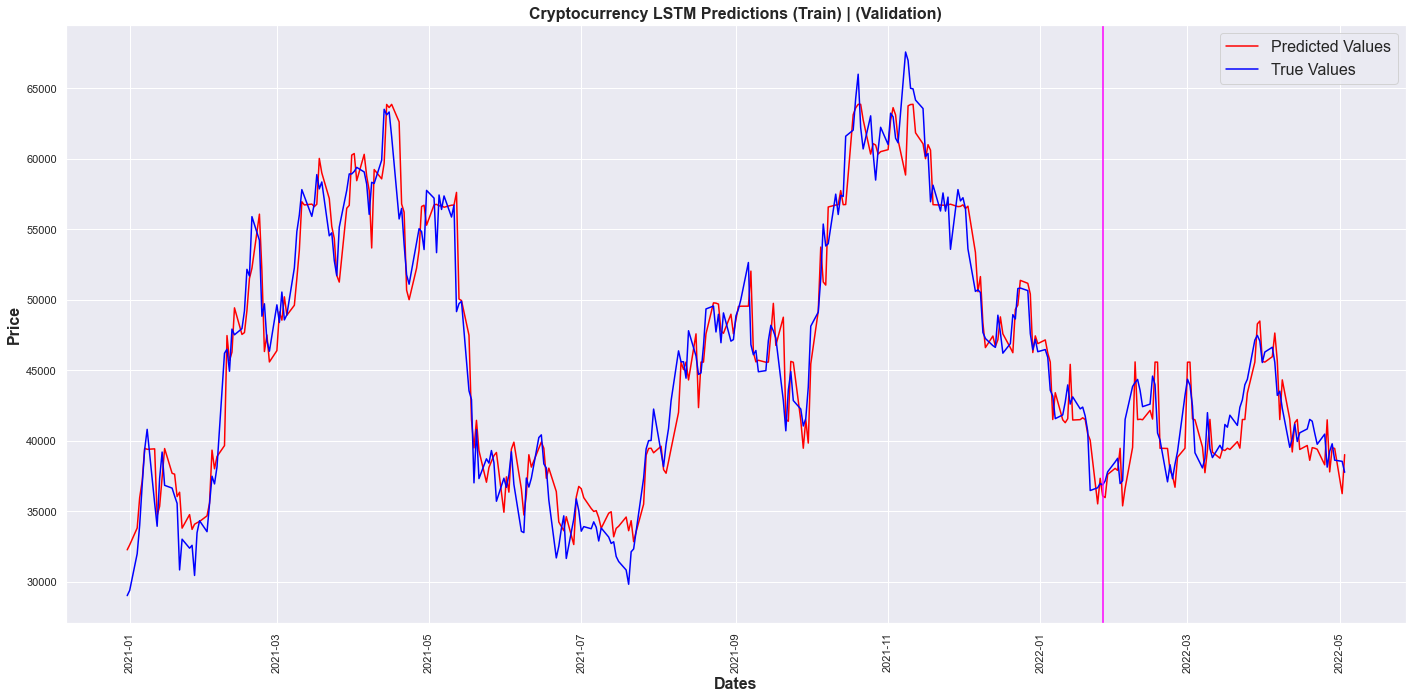

In [528]:
visualize_results((train_preds, val_preds), (train_labels, val_labels), dates)

Depending on the parameters we use for this model, we can obtain some very good predictions. We can functionize this model as well as the Auto Arima with exogenous variables for a StreamLit application, which will take place in the next notebook.

The reamin congruent with the Auto ARIMA model, I will use the Standard scaler on both models in the StreamLit application.